## This notebook is intended to solve the CartPole-v0 problem with the Advantage Actor Critic (A2C).

It will be a benchmark to future algorithms devoloped by Guilherme Viveiros.


> Solved Requirements for CartPole: Considered solved when the average return is greater than or equal to 195.0 over 100 consecutive trials.

In [1]:
import gym #envrionment to test the algorithms
import numpy as np #vector calculations
import tensorflow as tf #tensor / ML operations
#pip install jdc
import os #operative system
from tqdm import tqdm #progress bar
import jdc #jupyter dynamic classes
import collections #collect experiences from real environment to sample within DQN
import random #random environment's
import math#math
import time #time 
import tensorflow_probability as tfp#tensorflow probability

In [2]:
#ignore this, just plotting settings
import matplotlib
import matplotlib.pyplot as plt
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython: from IPython import display

## CartPole-V0 environment

In [3]:
#I want reproductible results, so let's define a define seed
#I always return state - reward - done in this order
class Environment():
    #initialize the environment
    def __init__(self,env_info={}):
        #seed
        #self.seed = env_info.get("sedd")
        #self.rand_generator = np.random.seed(seed = self.seed)
        #environment
        self.env = gym.make('CartPole-v0')
        #renderization
        if(env_info.get("render",False)):
            print("Rendering")
            self.env.render()
    
    #initialize the game
    def env_start(self):
        state = self.env.reset()
        #state,reward,done
        return (state,0,False)
    
    #take a step in the game
    def env_step(self,action):
        state, reward, done, info = self.env.step(action)
        return (state,reward,done)

    #end the game
    def env_end(self):
        self.env.close()

In [4]:
#Tested cell
env_info = {
    "render" : False
}

env = Environment(env_info)
#assert env.seed == 3

state,reward,done = env.env_start()
assert reward == 0 , print("Agent start error")
assert done == False , print("Agent start error")

state,reward,done = env.env_step(1)
assert reward == 1 , print("Agent step error")
assert done == False , print("Agent step error")

## Now let's define the core part, the Agent , the briliant agent that will solve this game :p

### Advantage Actor Critic 
   
> $A(at,st) = Q(at,st) - V(st)$
  
 Since it useless to define a DNN to predict value states and q values (value-action pairs), we can use the Bellman equations optimallity in our advantage
  
  > $ Q*(at,st) = E[Rt + V*(st')] $ (1)
  
 So
  
>$ A(at,st) = Rt + V(st') - V(st) $ (2)

And this is simply the TD Error
  
  Now I only need a NN to predict value states.
  
  The $E$ in equation (1) stands for expectation, it's the expectation cumulative reward of follwing $at$ in $st$. It's removed in equation **2** because I'm using TD(0), a boostrap method. Since I sample every step following the current policy I'm receiving the true rewards, thats why we can remove the expectation symbol in (2).
  

In [5]:
class ActorCritic():
    #initialize the parameters of the environment
    def agent_init(self,agent_info={}):
        raise NotImplementedError
    #create the actor critic model network
    def agent_create_model(self):
        raise NotImplementedError
    #check the model summary of actor and critic
    def check_a2c(self):
        self.actor.summary()
        self.critic.summary()
    #predict the action probs and value state from the a2c model
    def agent_forward(self,state):
        raise NotImplementedError
    #terminal state
    def agent_end(self):
        raise NotImplementedError

> All the parameters needed by the agent

In [6]:
%%add_to ActorCritic

def agent_init(self,agent_info={}):
    #discount factor
    self.discount = agent_info.get("discount")
    #number of available actions
    self.number_actions = agent_info.get("number_actions",2)
    #input dimensions
    self.in_dim = agent_info.get("input",2)
    
    self.agent_create_actor_critic()

In [7]:
%%add_to ActorCritic

def agent_create_actor_critic(self):
    #input is the state
    self.s = tf.keras.layers.Input(shape=(self.in_dim),name="Actor-input")
    
    #actor outputs a probability over actions
    self.dense1 = tf.keras.layers.Dense(64,activation='relu',name="Dense1-Actor")(self.s)
    self.dense2 = tf.keras.layers.Dense(32,activation='relu',name="Dense2-Actor")(self.dense1)
    self.dense3 = tf.keras.layers.Dense(self.number_actions, activation='softmax',name="Dense3-Actor-Probs")(self.dense2)
    self.actor = tf.keras.models.Model(inputs = self.s, outputs = self.dense3,name ="Actor Model")
    
    #critic outputs the value state for that state, to report the actor on how good/bad his action was
    self.dense4 = tf.keras.layers.Dense(64,activation='relu',name="Dense1-Critic")(self.s)
    self.dense5 = tf.keras.layers.Dense(32,activation='relu',name="Dense2-Critic")(self.dense4)
    self.dense6 = tf.keras.layers.Dense(1,name="Dense3-Critic-QValue")(self.dense5)
    self.critic = tf.keras.models.Model(inputs = self.s, outputs = self.dense6,name="Critic Model")
    

In [8]:
%%add_to ActorCritic

def agent_forward(self,state):
    
    action_probs = self.actor(state[np.newaxis])
    value = self.critic(state[np.newaxis])
    
    return action_probs,value

## Hyper-Parameters for A2C

In [9]:
in_dim = 4
out_dim = 2

discount_factor = 0.99

num_iterations = 2
num_episodes = 100


step_size = 1e-3
optimizer = tf.keras.optimizers.Adam(lr = step_size)
critic_optimizer = tf.keras.optimizers.Adam(lr = step_size)
actor_optimizer = tf.keras.optimizers.Adam(lr = step_size)

In [10]:
env_info = {
    "sedd" : 3,
    "render" : False
}

env = Environment(env_info)
#state,reward,done = env.env_start()

In [11]:
agent_info = {
    "discount" : discount_factor,
    "input" : in_dim,
    "number_actions": out_dim
}
agent = ActorCritic()
agent.agent_init(agent_info)

In [12]:
class PlotRewards():
    def __init__(self,plot_info,agent):
    
        self.epi = plot_info
        self.sum_reward_per_episode = []
        self.mean_reward = []

    def plot(self,reward_per_episode):
        plt.figure(figsize=(8,4))
        plt.clf()
        plt.title('Training --- Each iteration has 10 episodes inside')
        plt.xlabel('Episode')
        plt.ylabel('Duration')

       
        self.sum_reward_per_episode.append(reward_per_episode)
        
        #check if the game requirements are completed - 195.0 over 100
        if(len(self.sum_reward_per_episode) >= 100):
            tmp = np.asarray(self.sum_reward_per_episode[-100:]) >= 195
            if(tmp.sum() == 10):
                #print("Completed")
                return True
        
        #if the user want to check an average window of 10, put it innto the dict
        if(len(self.sum_reward_per_episode) >= self.epi):
            
            #moving average of epi
            self.mean_reward.append(
                np.mean(
                    self.sum_reward_per_episode[-self.epi:]
                )
            )
            
            plt.plot(self.mean_reward,label='Moving Average',c='r');
            
        
        #Plot the sum reward of every episode in each iteration that consis$
        plt.plot(self.sum_reward_per_episode,label='Mean Reward per Episode');
        plt.legend(loc='upper right',fontsize='large');
            
        plt.pause(0.001)
    
        print("Episode " + str(len(self.sum_reward_per_episode)))
        if is_ipython: display.clear_output(wait=True)
        
        return False

## Main function

In [13]:
checkpoint_directory = "/tmp/training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_directory, "ckpt")

checkpoint = tf.train.Checkpoint(
    optimizer1=critic_optimizer,
    optimizer2=actor_optimizer,
    actor= agent.actor,
    critic= agent.critic
)

# saving (checkpoint) the model every 2 epochs
#checkpoint.save(file_prefix = checkpoint_prefix)

#restore the last checkpoint
#status = checkpoint.restore(tf.train.latest_checkpoint(checkpoint_directory))

KeyboardInterrupt: 

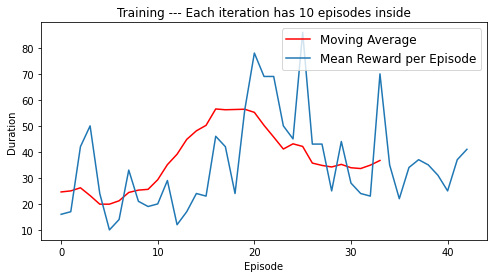

In [14]:
#have the agent and the environment all set up
#plot class with a window average of 10
plot = PlotRewards(10,agent)

#for each iteration -> 10 episodes
for iteration in range(num_iterations):
    
    start = time.time()
    
    for episode in range(num_episodes):
        #all the rewards received in one episode will be appended
        rewards_per_episode = []
        
        #start state
        state,reward,done = env.env_start()
        
        #Iterate until the terminal state
        while done != True:
        
            with tf.GradientTape() as tape:
            
                #Agent choose the action according to the policy network and the current state
                action_probs, state_value = agent.agent_forward(state)
            
                #use multionomial function from tensorflow probability to sample given action_probs
                dist = tfp.distributions.Categorical(probs=action_probs[0])
                action = dist.sample()
                            

                #log prob of the value for the choosen action
                log_prob = tf.math.log(action_probs[0][action])
                
                
                #new state after executing the action chosen by the agent
                next_state,reward,done = env.env_step(action.numpy())
                
                #append reward associated
                rewards_per_episode.append(reward)
                #calculate the value state for the next state
                _, next_state_value = agent.agent_forward(next_state)
            
                #compute the Advantage value
                advantage = tf.Variable(reward,dtype=tf.float32) + next_state_value - state_value 
                #compute the value error
                td_error = tf.Variable(reward,dtype=tf.float32) + discount_factor * next_state_value - state_value
        
                #calculate the loss
                actor_loss = -log_prob * advantage
                critic_loss = tf.square(td_error)
                   
                loss = 0.7 * actor_loss + 0.3 * critic_loss
                #update the actor and critic
                grads = tape.gradient(loss,agent.actor.trainable_variables+agent.critic.trainable_variables)
                
                optimizer.apply_gradients(zip(grads,agent.actor.trainable_variables + agent.critic.trainable_variables))
                
                state = next_state
       
        #1 in 1 episode -> plot the rewards as a function of time
        episode_sum_reward = np.sum(np.asarray(rewards_per_episode))
        tag = plot.plot(episode_sum_reward)
        
        if(tag == True):
            print("Solved")
            env.env_end()
            break
    
    end = time.time()
    print("Time elapsed in iteration {0} was = {1}".format(iteration+1,end-start))
    experiences = []
    
    if(iteration % 50 == 0):
        continue
        #tmp = file+str(iteration)+"reward-"+str(episode_sum_reward)+'.hdf5'
        #policy_network.save_weights(tmp)

env.env_end()

## O DE CIMA é TIPO TD, ESTE È MC vamos ver como corre

In [111]:
def cumulative_rewards(rewards):
    #G(t) = R(t+1) + γ*R(t+2) + γ^2*R(t+3) + ...
    #Cumulative reward

    rewards.reverse()

    for r in rewards:
        sum_reward = r + discount_factor*sum_reward
        to_return.append(sum_reward)

    return to_return.reverse()

In [108]:
from collections import namedtuple

#state,next state, log likelihood of the choosen action, done
Experience = namedtuple('Experience',
                   ('state', 'next_state', 'log_likelihood','done')
                  )

In [109]:
def backprop(experiences,rewards):
    #'state', 'next_state', 'log_likelihood','done')
    experiences = Experience(*zip(*experiences))
    
    state_values = experiences.state
    next_state_values = experiences.next_state
    log_likelihoods = experiences.log_likelihood
    done = experiences.done
    
    with tf.GradientTape() as tape:
        #td target    
        td_target =  tf.Variable(rewards,dtype=tf.float32) + next_state_values
        #Advantage    
        advantage = td_target - state_values
    
        #calculate the loss
        actor_loss = tf.reduce_mean(-log_prob * advantage)
        critic_loss = tf.reduce_mean(tf.square(advantage))
        
        loss = actor_loss + critic_loss
                   
        #update the actor and critic
        grads = tape.gradient(loss,agent.actor.trainable_variables + agent.critic.trainable_variables)
        #apply the gradients
        optimizer.apply_gradients(zip(grads,agent.actor.trainable_variables + agent.critic.trainable_variables))

In [110]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

#have the agent and the environment all set up
import tensorflow_probability as tfp

#plot class with a window average of 10
plot = PlotRewards(10,agent)

#for each iteration -> 10 episodes
for iteration in range(num_iterations):
    
    for episode in range(num_episodes):
        
        #save each experience -> (sate,next_state,value,)
        experiences = []
        #all the rewards received in one episode will be appended
        rewards_per_episode = []
        
        #start state
        state,reward,done = env.env_start()
        rewards_per_episode.append(reward)
        
        #Iterate until the terminal state
        while done != True:
            
        
            #Agent choose the action according to the policy network and the current state
            action_probs, state_value = agent.agent_forward(state)
            
            #use multionomial function from tensorflow probability to sample given action_probs
            dist = tfp.distributions.Categorical(probs=action_probs[0])
            action = dist.sample()
            #log prob of the value for the choosen action
            log_prob = dist.log_prob(action)
            
            #new state after executing the action chosen by the agent
            next_state,reward,done = env.env_step(action.numpy())
            
            #state,next state, log likelihood of the choosen action, reward
            experiences.append(Experience(state,next_state,log_prob,done))
            
            # append experience
            rewards_per_episode.append(reward)
            
            state = next_state
        
        #reach the end of the episode
        rewards = cumulative_rewards(rewards_per_episode)
        
        #backpropagation
        backprop(experiences,rewards)
        
        #1 in 1 episode -> plot the rewards as a function of time
        episode_sum_reward = np.sum(np.asarray(rewards_per_episode))
        tag = plot.plot(episode_sum_reward)
        
        
       
        

NameError: name 'gamma' is not defined

In [ ]:
 #compute the TD target
                td_target =  tf.Variable(reward,dtype=tf.float32) + next_state_value
                #Advantage    
                advantage = td_target - state_value 
        
                #calculate the loss
                actor_loss = -log_prob * advantage
                critic_loss = tf.square(advantage) 
                   
                #update the actor and critic
                grads_actor = tape1.gradient(actor_loss,agent.actor.trainable_variables)
                grads_critic = tape2.gradient(critic_loss, agent.critic.trainable_variables)
                
                actor_optimizer.apply_gradients(zip(grads_actor,agent.actor.trainable_variables))
                critic_optimizer.apply_gradients(zip(grads_critic,agent.critic.trainable_variables))
                
        
                state = next_state